In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from IPython.display import clear_output

from PIL import Image

batch_size = 16
img_width = 200
img_height = 50

downsample_factor = 4




In [2]:
train_df = pd.read_csv('/kaggle/input/handwriting-recognitionocr/CSV/written_name_train.csv')
# valid_df = pd.read_csv('/kaggle/input/handwriting-recognitionocr/CSV/written_name_validation.csv')
test_df = pd.read_csv('/kaggle/input/handwriting-recognitionocr/CSV/written_name_test.csv')

train_subset_df = train_df.iloc[:20000]
# valid_subset_df = valid_df.sample(n=6000, random_state=1)
test_subset_df = test_df.iloc[:4000]

train_subset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FILENAME  20000 non-null  object
 1   IDENTITY  19969 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [3]:
test_subset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FILENAME  4000 non-null   object
 1   IDENTITY  3993 non-null   object
dtypes: object(2)
memory usage: 62.6+ KB


In [4]:
train_subset_df = train_subset_df.dropna(subset=['IDENTITY'])
test_subset_df = test_subset_df.dropna(subset=['IDENTITY'])

train_subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19969 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FILENAME  19969 non-null  object
 1   IDENTITY  19969 non-null  object
dtypes: object(2)
memory usage: 468.0+ KB


In [5]:
train_subset_df.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [6]:
train_image_dir = '/kaggle/input/handwriting-recognitionocr/train_v2/train'
# valid_image_dir = '/kaggle/input/handwriting-recognitionocr/validation_v2/validation'

test_image_dir = '/kaggle/input/handwriting-recognitionocr/test_v2/test'

print(os.listdir(train_image_dir)[:5])



['TRAIN_03637.jpg', 'TRAIN_174010.jpg', 'TRAIN_30370.jpg', 'TRAIN_11814.jpg', 'TRAIN_92610.jpg']


In [7]:

def check_filenames(df, image_dir):
    filenames = df['FILENAME'].values
    image_files = set(os.listdir(image_dir))
    missing_files = [filename for filename in filenames if filename not in image_files]
    if missing_files:
        print(f"Missing files: {missing_files[:10]}")
    else:
        print("files are present.")

print("training files:")
check_filenames(train_df, train_image_dir)



training files:
files are present.


Sample Training Images:


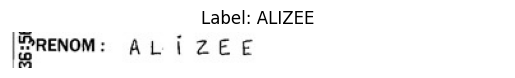

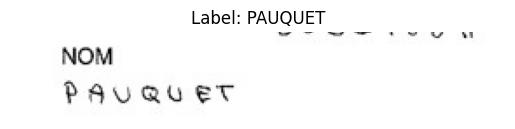

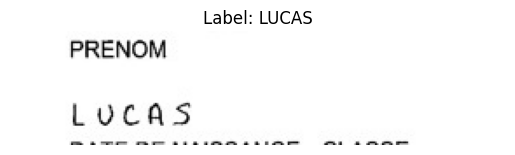

In [8]:
def display_random_samples(df, image_dir, num_samples=3):
    sample_df = df.sample(num_samples)
    for i, row in sample_df.iterrows():
        img_path = os.path.join(image_dir, row['FILENAME'])
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(f'Label: {row["IDENTITY"]}')
        plt.axis('off')
        plt.show()

print("Sample Training Images:")
display_random_samples(train_df, train_image_dir)

# print("Sample test Images:")
# display_random_samples(test_df, test_image_dir)


In [9]:
def load_images(df, image_dir):
    images = []
    for filename in df['FILENAME']:
        img_path = os.path.join(image_dir, filename)
        if os.path.exists(img_path):
            img = Image.open(img_path)
            images.append(img)
        else:
            print(f"File not found: {img_path}")
    return images

train_images = load_images(train_subset_df, train_image_dir)


train_subset_df['FILENAME'] = [train_image_dir + f"/{filename}" for filename in train_subset_df['FILENAME']]

test_subset_df['FILENAME'] = [test_image_dir + f"/{filename}" for filename in test_subset_df['FILENAME']]


print(train_subset_df[:5])

                                            FILENAME   IDENTITY
0  /kaggle/input/handwriting-recognitionocr/train...  BALTHAZAR
1  /kaggle/input/handwriting-recognitionocr/train...      SIMON
2  /kaggle/input/handwriting-recognitionocr/train...      BENES
3  /kaggle/input/handwriting-recognitionocr/train...    LA LOVE
4  /kaggle/input/handwriting-recognitionocr/train...     DAPHNE


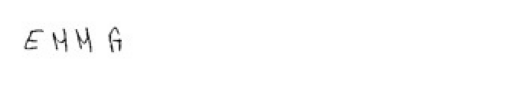

In [10]:
import matplotlib.pyplot as plt

if train_images:
    plt.imshow(train_images[10])
    plt.axis('off')
    plt.show()


In [11]:
labels = train_subset_df['IDENTITY'].tolist()
char_set = set(char for label in labels for char in label)

print("Num of images: ", len(train_images))
print("Num of labels: ", len(labels))
print("Num of char_set: ", len(char_set))
print(char_set)


Num of images:  19969
Num of labels:  19969
Num of char_set:  39
{' ', 'W', 'O', 'F', 'o', 'Z', 't', 'c', 'N', 'V', 'P', 'A', 'H', 'r', 'I', 'C', 'J', 'T', 's', 'y', "'", 'X', 'E', 'D', 'Q', 'l', 'p', 'e', '-', 'R', 'B', 'L', 'M', 'U', 'G', 'K', 'u', 'S', 'Y'}


In [12]:
max_length = max(len(label) for label in labels)

In [13]:
from tensorflow.keras.layers import StringLookup

char_to_num = StringLookup(
    vocabulary=list(char_set), num_oov_indices=0, mask_token=None
)

num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


In [14]:

images = train_subset_df['FILENAME']
images[:10]

0    /kaggle/input/handwriting-recognitionocr/train...
1    /kaggle/input/handwriting-recognitionocr/train...
2    /kaggle/input/handwriting-recognitionocr/train...
3    /kaggle/input/handwriting-recognitionocr/train...
4    /kaggle/input/handwriting-recognitionocr/train...
5    /kaggle/input/handwriting-recognitionocr/train...
6    /kaggle/input/handwriting-recognitionocr/train...
7    /kaggle/input/handwriting-recognitionocr/train...
8    /kaggle/input/handwriting-recognitionocr/train...
9    /kaggle/input/handwriting-recognitionocr/train...
Name: FILENAME, dtype: object

In [15]:
def split_data(images, labels, train_size=0.9, shuffle=False):
    size =len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    train_samples = int(size * train_size)
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    
    return x_train, x_valid, y_train, y_valid

x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

In [16]:
def encoded(img_path, label):
    try:
        img = tf.io.read_file(img_path)
        
        img = tf.image.decode_jpeg(contents = img, channels = 1)
        img = tf.image.convert_image_dtype(image = img, dtype = tf.float32)
        img = tf.image.resize(images = img, size = (img_height, img_width))
        img = tf.transpose(img, perm=[1, 0, 2])
        img = tf.cast(img, dtype = tf.float32)
    except tf.errors.InvalidArgumentError:
        img = tf.zeros([img_height, img_width, 1], dtype=tf.float32)
        
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)
    pad_size =  max_length - tf.shape(label)[0]
    label = tf.pad(label, paddings = [[0, pad_size]], constant_values=len(char_set)+1)
    return {"image": img, "label": label}


In [17]:
# x_train = (x_train).tolist()
# y_train = y_train.tolist()

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
    .map(encoded, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encoded, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)


In [19]:
for batch in train_dataset.take(1):
    for label in batch['label']:
        print("Numeric Label:", label.numpy())
        decoded_label = num_to_char(label)
        
        decoded_label_no_pad = tf.strings.regex_replace(decoded_label, r'\[UNK\]', '')
        decoded_string = tf.strings.reduce_join(decoded_label_no_pad).numpy().decode('utf-8')
        
        print("Decoded Label (with padding removed):", decoded_string)

Numeric Label: [30 11 31 17 12 11  5 11 29 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40]
Decoded Label (with padding removed): RPBJAPoP-
Numeric Label: [37 14 32  2  8 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40]
Decoded Label (with padding removed): urLWc
Numeric Label: [30 22  8 22 37 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40]
Decoded Label (with padding removed): RXcXu
Numeric Label: [31 11  0 31  2  9 22 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40]
Decoded Label (with padding removed): BPBWNX
Numeric Label: [23 11 10 12  8 22 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40]
Decoded Label (with padding removed): EPVAcX
Numeric Label: [31 33 15 14 22 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40]
Decoded Label (with padding removed): BMIrX
Numeric Label: [ 8 11 37 37 14 32 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40]
Decoded Label (with padding removed): cPuurL
Numeric Label: [11 37 37 29 11  2 33 14 40 40 40 40 40 40 40 4

In [20]:
print(f"Training Data Size   : {tf.data.Dataset.cardinality(train_dataset).numpy() * batch_size}")

Training Data Size   : 17984


In [21]:
for sample in train_dataset.take(1):
    print(sample["label"])  # Check the format of labels


tf.Tensor(
[[30 11 31 17 12 11  5 11 29 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40]
 [37 14 32  2  8 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40]
 [30 22  8 22 37 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40]
 [31 11  0 31  2  9 22 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40]
 [23 11 10 12  8 22 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40]
 [31 33 15 14 22 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40]
 [ 8 11 37 37 14 32 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40]
 [11 37 37 29 11  2 33 14 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40]
 [31 11  9 14 11  8 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40]
 [32 11 22  9 11 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40]
 [22 32 32 11 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40]
 [32  2 33 31 14  8 14 22 29 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40]
 [22 31 14 37 22 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40]
 [12  2  8  8 

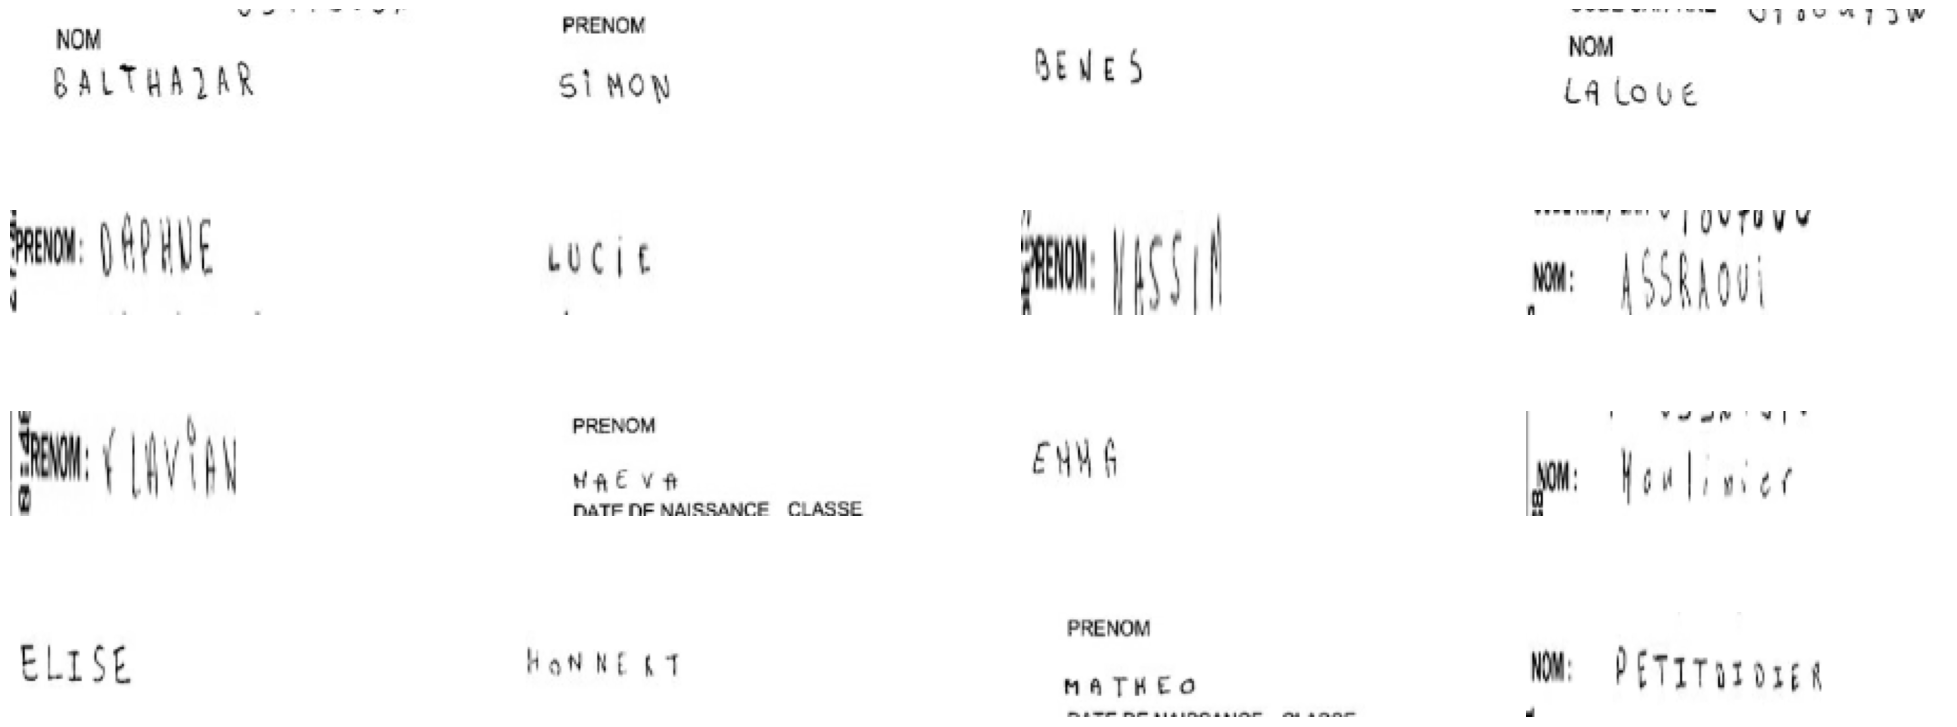

In [22]:
_, ax = plt.subplots(4, 4, figsize=(25, 10))
for batch in train_dataset.take(1):
    images = batch["image"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
#         label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].axis("off")
plt.show()

In [23]:
from IPython.display import clear_output as cls
def show_images(data, GRID=[4,4], FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID
    data = next(iter(data))
    images, labels = data['image'], data['label']
    
    for index, (image, label) in enumerate(zip(images, labels)):
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()
        
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1,0,2]), cmap=cmap)
        plt.axis('off')
        
        if model is not None and decode_pred is not None:
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            plt.title(text_label)
    
    cls()
    plt.show()


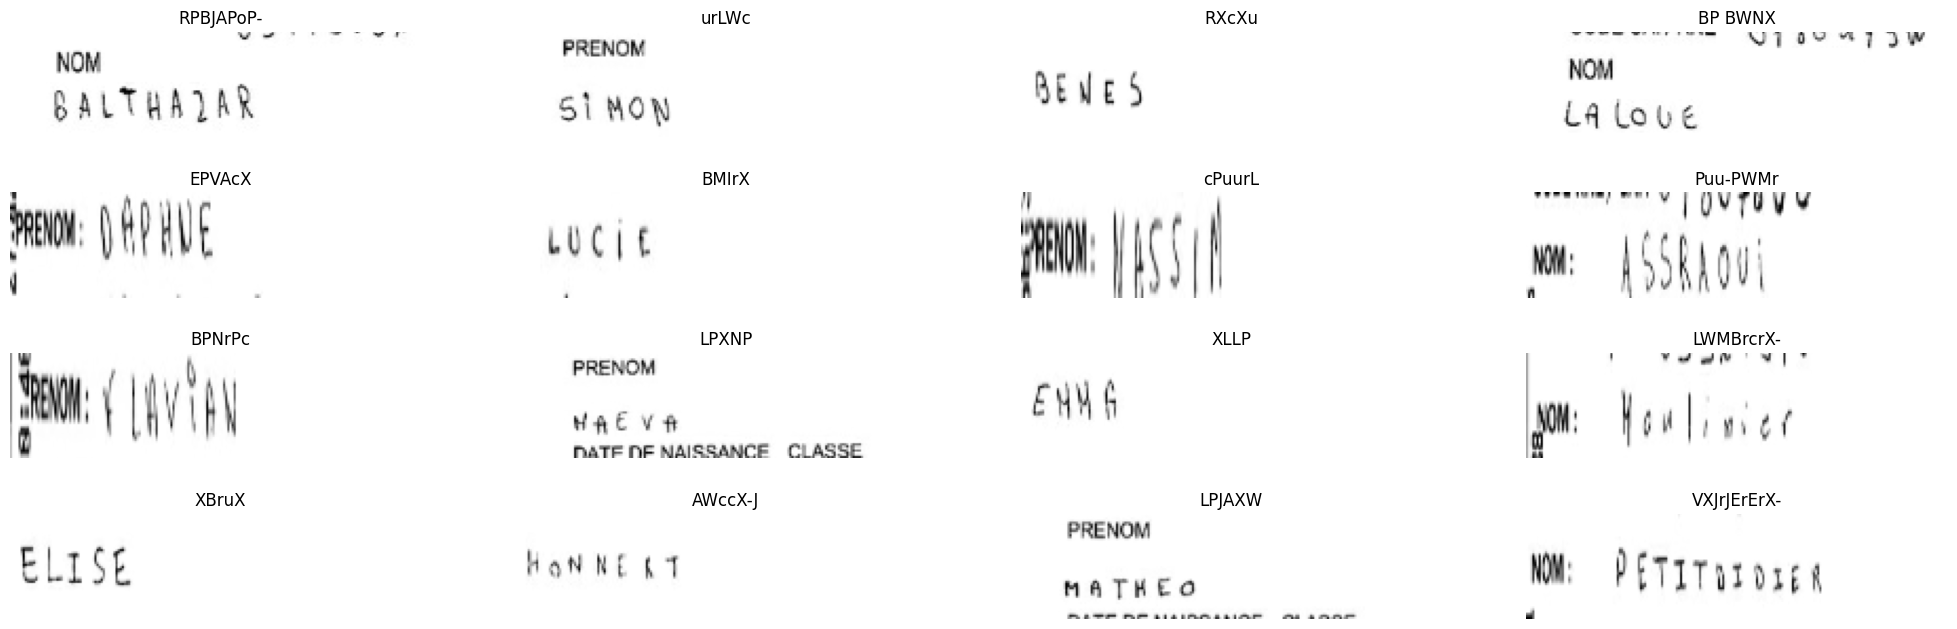

In [24]:
show_images(data=train_dataset, cmap='gray')

In [25]:
class CTCLayer(layers.Layer):
    
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)
        
        self.loss_fn = keras.backend.ctc_batch_cost
    
    def call(self, y_true, y_pred):
        
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_len = tf.cast(tf.shape(y_pred)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        
        loss = self.loss_fn(y_true, y_pred, input_len, label_len)
        
        self.add_loss(loss)
        
        return y_pred

In [26]:

def build_ocr_model():
    images = layers.Input(shape=(img_width, img_height, 1), name="image")
    labels = layers.Input(shape=(None,), name="label")

    col = layers.Conv2D(filters=32, kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer='he_normal')(images)
    col = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(col)

    col = layers.Conv2D(filters=64, kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer='he_normal')(col)
    col = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(col)

    den = layers.Reshape(target_shape=((img_width//4), (img_height//4)*64))(col)
    den = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(den)
    
    den = layers.Dropout(0.3)(den)

    col = layers.Bidirectional(
        layers.LSTM(128, return_sequences=True)
    )(den)
    col = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(col)

    output = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation='softmax')(col)

    ctc_layer = CTCLayer()(labels, output)

    ocr_model = keras.Model(
        inputs=[images, labels],
        outputs=[ctc_layer]
    )

    return ocr_model

model = build_ocr_model()

In [27]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 50,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 200, 50,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 100, 25,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 100, 25,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 50, 12,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 768)   │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 50, 64)    │     49,216 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50, 64)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50, 256)   │    197,632 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 50, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 50, 40)    │      5,160 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_layer           │ (None, 50, 40)    │          0 │ label[0][0],      │
│ (CTCLayer)          │                   │            │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 435,176 (1.66 MB)

 Trainable params: 435,176 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:

model.compile(
    optimizer='adam'
)

history = model.fit(
    train_dataset, 
    validation_data=validation_dataset, 
    epochs=30,
    batch_size=32
)

Epoch 1/30
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 155s 131ms/step - loss: 391.9670 - val_loss: 314.0857
Epoch 2/30
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 146s 130ms/step - loss: 307.6613 - val_loss: 297.9868
Epoch 3/30
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 148s 132ms/step - loss: 296.9002 - val_loss: 294.6038
Epoch 4/30
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 150s 133ms/step - loss: 292.7592 - val_loss: 287.9719
Epoch 5/30
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 149s 133ms/step - loss: 282.2980 - val_loss: 259.1599
Epoch 6/30
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 146s 130ms/step - loss: 251.9040 - val_loss: 208.8225
Epoch 7/30
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 146s 129ms/step - loss: 204.4530 - val_loss: 165.1296
Epoch 8/30
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 145s 129ms/step - loss: 165.9724 - val_loss: 133.9231
Epoch 9/30
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 202s 129ms/step - loss: 139.7800 - val_loss: 112.3790
Epoch 10/30
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 203s 130ms/step - loss: 119.5494 - val_loss: 97.9238
Epoch 11/30
1124/1124 ━━━━━━━━━━━━━━━━━━

In [29]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Set up data generators
# train_datagen = ImageDataGenerator(rescale=1./255)
# valid_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(
#     '/kaggle/working/train_subset',
#     target_size=(128, 128),
#     batch_size=32,
#     class_mode='categorical'
# )

# valid_generator = valid_datagen.flow_from_directory(
#     '/kaggle/working/valid_subset',
#     target_size=(128, 128),
#     batch_size=6,
#     class_mode='categorical'
# )

# test_generator = test_datagen.flow_from_directory(
#     '/kaggle/working/test_subset',
#     target_size=(128, 128),
#     batch_size=4,
#     class_mode=None,  # No labels for test data
#     shuffle=False
# )


In [30]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

# # Build a simple CNN model
# model = Sequential([
#     Input(shape=(128, 128, 3)),  # Define the input shape
#     Conv2D(32, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dense(train_generator.num_classes, activation='softmax')
# ])

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# # Train the model
# history = model.fit(
#     train_generator,
#     epochs=10,
#     validation_data=valid_generator
# )
